In [342]:
import pandas as pd
import numpy as np
import shap
import xgboost 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [343]:
data = pd.read_csv("Cleaned_Students_Performance.csv")
data.head()


,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score,average_score
0,0,group B,bachelor's degree,1,0,72,72,74,218,72.666667
1,0,group C,some college,1,1,69,90,88,247,82.333333
2,0,group B,master's degree,1,0,90,95,93,278,92.666667
3,1,group A,associate's degree,0,0,47,57,44,148,49.333333
4,1,group C,some college,1,0,76,78,75,229,76.333333


In [344]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       1000 non-null   int64  
 1   race_ethnicity               1000 non-null   object 
 2   parental_level_of_education  1000 non-null   object 
 3   lunch                        1000 non-null   int64  
 4   test_preparation_course      1000 non-null   int64  
 5   math_score                   1000 non-null   int64  
 6   reading_score                1000 non-null   int64  
 7   writing_score                1000 non-null   int64  
 8   total_score                  1000 non-null   int64  
 9   average_score                1000 non-null   float64
dtypes: float64(1), int64(7), object(2)
memory usage: 78.3+ KB


In [345]:
data.describe()

,gender,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score,average_score
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.482000,0.645000,0.358000,66.08900,69.169000,68.054000,203.312000,67.770667
std,0.499926,0.478753,0.479652,15.16308,14.600192,15.195657,42.771978,14.257326
min,0.000000,0.000000,0.000000,0.00000,17.000000,10.000000,27.000000,9.000000
25%,0.000000,0.000000,0.000000,57.00000,59.000000,57.750000,175.000000,58.333333
50%,0.000000,1.000000,0.000000,66.00000,70.000000,69.000000,205.000000,68.333333
75%,1.000000,1.000000,1.000000,77.00000,79.000000,79.000000,233.000000,77.666667
max,1.000000,1.000000,1.000000,100.00000,100.000000,100.000000,300.000000,100.000000


In [346]:
# Load California housing dataset
X = data.drop(['writing_score',"reading_score",'math_score','average_score','total_score'],axis=1)
y = data['average_score']
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course
0,0,group B,bachelor's degree,1,0
1,0,group C,some college,1,1
2,0,group B,master's degree,1,0
3,1,group A,associate's degree,0,0
4,1,group C,some college,1,0


In [347]:
for column in X.columns:
    print(X[column].describe())

count    1000.000000
mean        0.482000
std         0.499926
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64
count        1000
unique          5
top       group C
freq          319
Name: race_ethnicity, dtype: object
count             1000
unique               6
top       some college
freq               226
Name: parental_level_of_education, dtype: object
count    1000.000000
mean        0.645000
std         0.478753
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: lunch, dtype: float64
count    1000.000000
mean        0.358000
std         0.479652
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: test_preparation_course, dtype: float64


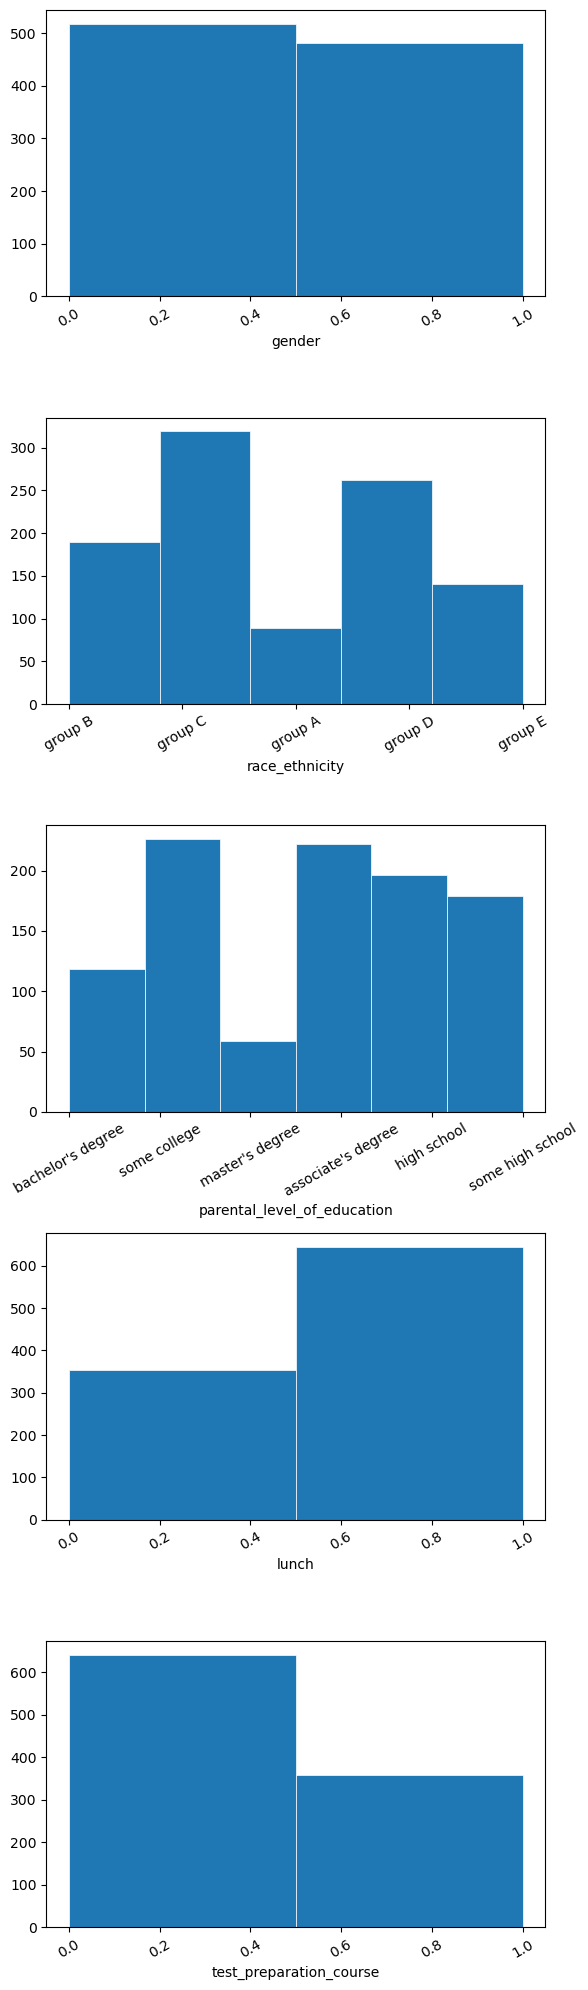

In [348]:
fig, axes = plt.subplots(len(X.columns),1,figsize=(6, 4 * len(X.columns)))

for i, column in enumerate(X.columns):
    bins=len(X[column].unique())
    axes[i].hist(X[column], bins=bins, linewidth=0.5, edgecolor="white")
    axes[i].set_xlabel(column)
    axes[i].tick_params(axis='x', rotation=30)  


plt.tight_layout()
plt.show()

In [349]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Define the ordinal categories in increasing order
education_order = [
    "some high school", "high school", "some college", 
    "associate's degree", "bachelor's degree", "master's degree"
]

# Define categorical and numerical features
categorical_features = ['race_ethnicity', 'parental_level_of_education']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Create a transformer for ordinal encoding
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[education_order]))  # Encode with order
])

# Create a transformer for other categorical data (e.g., one-hot encoding)
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a transformer for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine transformers in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('ord', ordinal_transformer, ['parental_level_of_education']),
        ('cat', onehot_transformer, ['race_ethnicity'])
    ]
)

# Define the preprocessing and model pipeline for training Model 1
pipeline_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100))
])

# Define the preprocessing and model pipeline for training Model 2
pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor(max_depth=7, learning_rate=0.01, n_estimators=500))
])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [350]:
# Train the models
pipeline_1.fit(X_train, y_train)
pipeline_2.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'lunch',
                                                   'test_preparation_course']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['some '
                                                                                               'high '
                                                                                               'school',
                                                                                               'high '
                                                                                               'school',
                                                                                               'some '
                                                                                               'college',
                                                                                               "associate's "
                                                                                               'degree',
                                                                                               "bachelor's "
                                                                                               'degree',
                                                                                               "master's "
                                                                                               'degree']]))]),
                                                  ['par...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [351]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_1 = pipeline_1.predict(X_test)
y_pred_2 = pipeline_2.predict(X_test)

print("Model 1 Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_1))
print("MSE:", mean_squared_error(y_test, y_pred_1))
print("R² Score:", r2_score(y_test, y_pred_1))

print("\nModel 2 Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_2))
print("MSE:", mean_squared_error(y_test, y_pred_2))
print("R² Score:", r2_score(y_test, y_pred_2))


Model 1 Performance:
MAE: 10.757018025716148
MSE: 193.25690935233447
R² Score: 0.09847457858088982

Model 2 Performance:
MAE: 11.344479160308838
MSE: 214.90446790745764
R² Score: -0.0025092590190491926


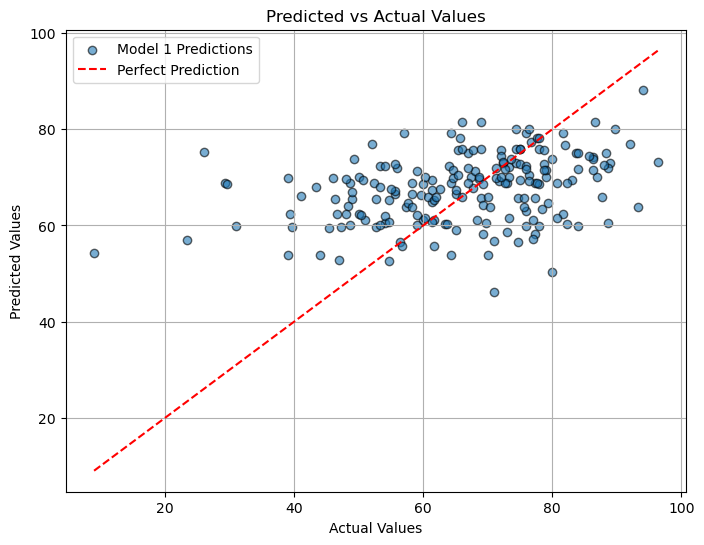

In [352]:
import matplotlib.pyplot as plt

# Scatter plot: Predicted values vs. Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_1, alpha=0.6, edgecolor='k', label='Model 1 Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')  # Diagonal line
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


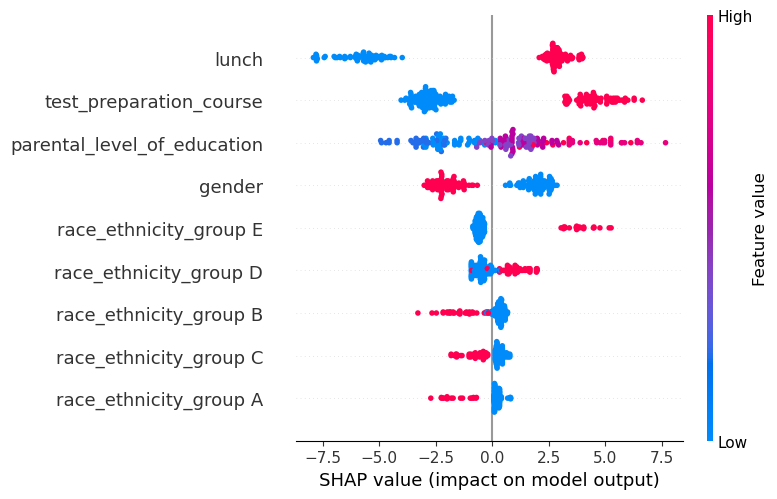

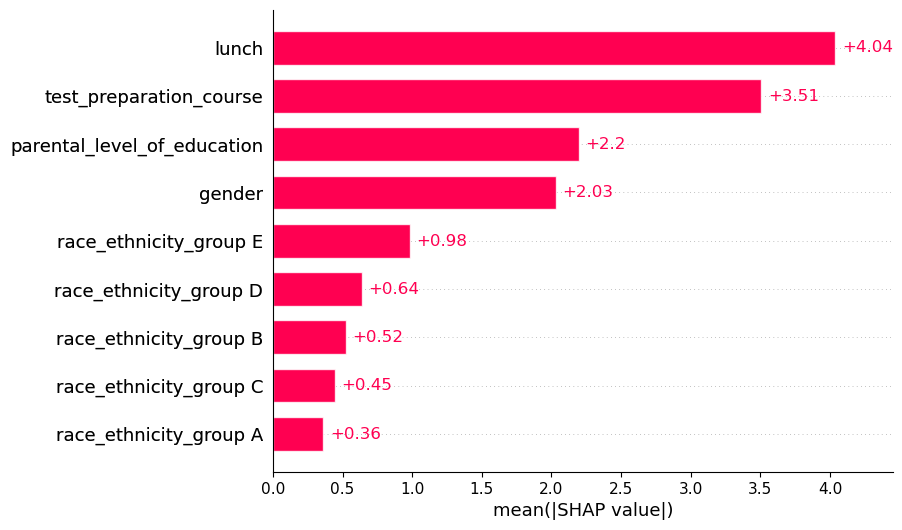

In [353]:
chosen_pipeline = pipeline_1
chosen_model = chosen_pipeline.named_steps['model']

# Preprocess the test data using the pipeline's preprocessor
X_test_transformed = chosen_pipeline.named_steps['preprocessor'].transform(X_test)

# Extract the original feature names for transformed data
encoded_features = (
    numerical_features + 
    ['parental_level_of_education'] + 
    list(chosen_pipeline.named_steps['preprocessor']
         .transformers_[2][1]
         .named_steps['onehot']
         .get_feature_names_out(['race_ethnicity']))
)

# Ensure SHAP outputs display the correct feature names
explainer = shap.Explainer(chosen_model, X_test_transformed)
shap_values = explainer(X_test_transformed)
shap_values.feature_names = encoded_features

# Plot a summary of feature importance (global view)
shap.summary_plot(shap_values, X_test_transformed)

# Bar plot of average feature importance
shap.plots.bar(shap_values)

# Force plot for a specific prediction (e.g., the first test example)
shap.plots.force(shap_values[0])

plt.show()

In [354]:
# Load California housing dataset
X = data.drop(['reading_score','math_score','average_score','total_score'],axis=1)
y = data['average_score']

In [355]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Define the ordinal categories in increasing order
education_order = [
    "some high school", "high school", "some college", 
    "associate's degree", "bachelor's degree", "master's degree"
]

# Define categorical and numerical features
categorical_features = ['race_ethnicity', 'parental_level_of_education']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Create a transformer for ordinal encoding
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[education_order]))  # Encode with order
])

# Create a transformer for other categorical data (e.g., one-hot encoding)
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a transformer for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine transformers in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('ord', ordinal_transformer, ['parental_level_of_education']),
        ('cat', onehot_transformer, ['race_ethnicity'])
    ]
)

# Define the preprocessing and model pipeline for training Model 1
pipeline_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100))
])

# Define the preprocessing and model pipeline for training Model 2
pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor(max_depth=7, learning_rate=0.01, n_estimators=500))
])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [356]:
pipeline_1.fit(X_train, y_train)
pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'lunch',
                                                   'test_preparation_course',
                                                   'writing_score']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['some '
                                                                                               'high '
                                                                                               'school',
                                                                                               'high '
                                                                                               'school',
                                                                                               'some '
                                                                                               'college',
                                                                                               "associate's "
                                                                                               'degree',
                                                                                               "bachelor's "
                                                                                               'degree',
                                                                                               "master's "
                                                                                               'deg...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [357]:
y_pred_1 = pipeline_1.predict(X_test)
y_pred_2 = pipeline_2.predict(X_test)

print("Model 1 Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_1))
print("MSE:", mean_squared_error(y_test, y_pred_1))
print("R² Score:", r2_score(y_test, y_pred_1))

print("\nModel 2 Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_2))
print("MSE:", mean_squared_error(y_test, y_pred_2))
print("R² Score:", r2_score(y_test, y_pred_2))

Model 1 Performance:
MAE: 2.2914181995391854
MSE: 8.776854531124092
R² Score: 0.9590567938480266

Model 2 Performance:
MAE: 2.3343482907613127
MSE: 9.42334276916432
R² Score: 0.9560409866347427


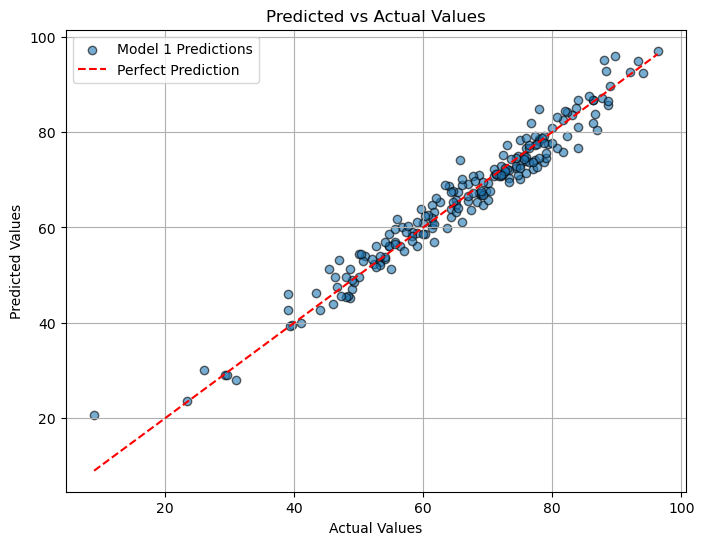

In [358]:
import matplotlib.pyplot as plt

# Scatter plot: Predicted values vs. Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_1, alpha=0.6, edgecolor='k', label='Model 1 Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')  # Diagonal line
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
chosen_pipeline = pipeline_1
chosen_model = chosen_pipeline.named_steps['model']

# Preprocess the test data using the pipeline's preprocessor
X_test_transformed = chosen_pipeline.named_steps['preprocessor'].transform(X_test)

# Extract the original feature names for transformed data
encoded_features = (
    numerical_features + 
    ['parental_level_of_education'] + 
    list(chosen_pipeline.named_steps['preprocessor']
         .transformers_[2][1]
         .named_steps['onehot']
         .get_feature_names_out(['race_ethnicity']))
)

# Ensure SHAP outputs display the correct feature names
explainer = shap.Explainer(chosen_model, X_test_transformed)
shap_values = explainer(X_test_transformed)
shap_values.feature_names = encoded_features

# Plot a summary of feature importance (global view)
shap.summary_plot(shap_values, X_test_transformed)

# Bar plot of average feature importance
shap.plots.bar(shap_values)

# Force plot for a specific prediction (e.g., the first test example)
shap.plots.force(shap_values[0])

plt.show()

In [ ]:
# Load California housing dataset
X = data.drop(['reading_score','writing_score','average_score','total_score'],axis=1)
y = data['average_score']

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Define the ordinal categories in increasing order
education_order = [
    "some high school", "high school", "some college", 
    "associate's degree", "bachelor's degree", "master's degree"
]

# Define categorical and numerical features
categorical_features = ['race_ethnicity', 'parental_level_of_education']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Create a transformer for ordinal encoding
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[education_order]))  # Encode with order
])

# Create a transformer for other categorical data (e.g., one-hot encoding)
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a transformer for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine transformers in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('ord', ordinal_transformer, ['parental_level_of_education']),
        ('cat', onehot_transformer, ['race_ethnicity'])
    ]
)

# Define the preprocessing and model pipeline for training Model 1
pipeline_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100))
])

# Define the preprocessing and model pipeline for training Model 2
pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor(max_depth=7, learning_rate=0.01, n_estimators=500))
])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pipeline_1.fit(X_train, y_train)
pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'lunch',
                                                   'test_preparation_course',
                                                   'math_score']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['some '
                                                                                               'high '
                                                                                               'school',
                                                                                               'high '
                                                                                               'school',
                                                                                               'some '
                                                                                               'college',
                                                                                               "associate's "
                                                                                               'degree',
                                                                                               "bachelor's "
                                                                                               'degree',
                                                                                               "master's "
                                                                                               'degree...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred_1 = pipeline_1.predict(X_test)
y_pred_2 = pipeline_2.predict(X_test)

print("Model 1 Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_1))
print("MSE:", mean_squared_error(y_test, y_pred_1))
print("R² Score:", r2_score(y_test, y_pred_1))

print("\nModel 2 Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_2))
print("MSE:", mean_squared_error(y_test, y_pred_2))
print("R² Score:", r2_score(y_test, y_pred_2))

Model 1 Performance:
MAE: 2.7759008407592773
MSE: 13.00460777748088
R² Score: 0.9393347200559374

Model 2 Performance:
MAE: 3.143148034413656
MSE: 16.565275160485644
R² Score: 0.9227245394742729


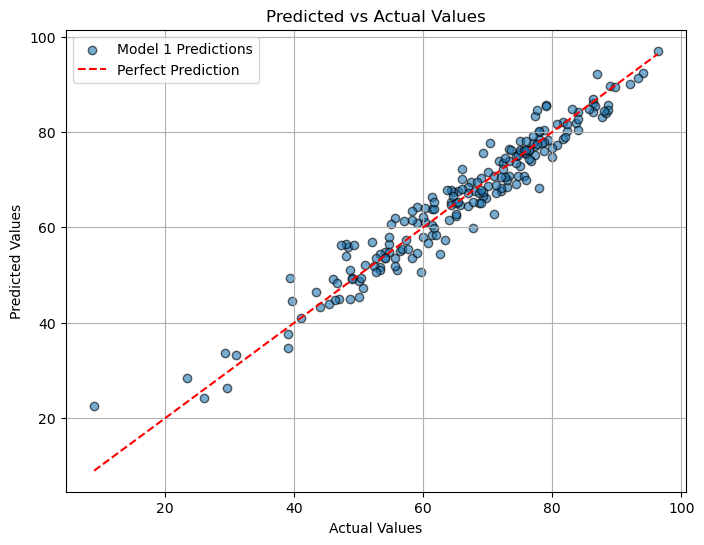

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot: Predicted values vs. Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_1, alpha=0.6, edgecolor='k', label='Model 1 Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')  # Diagonal line
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

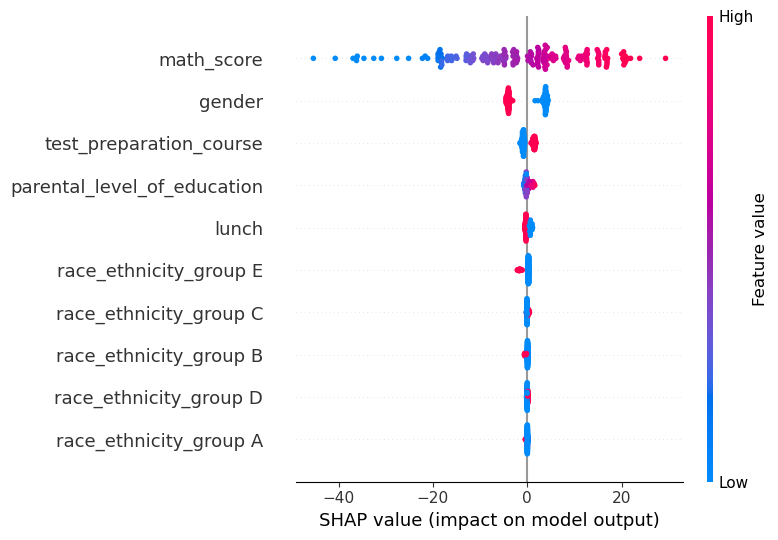

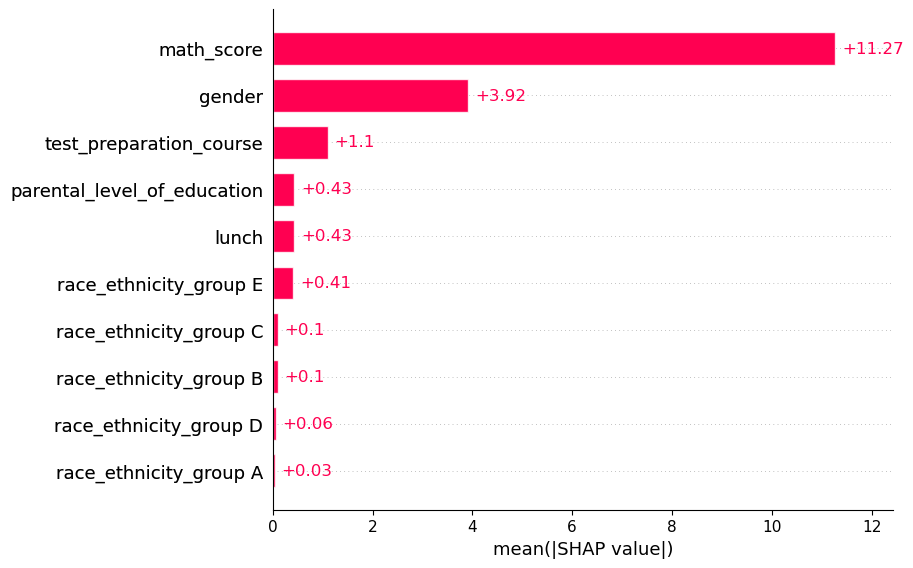

In [ ]:
chosen_pipeline = pipeline_1
chosen_model = chosen_pipeline.named_steps['model']

# Preprocess the test data using the pipeline's preprocessor
X_test_transformed = chosen_pipeline.named_steps['preprocessor'].transform(X_test)

# Extract the original feature names for transformed data
encoded_features = (
    numerical_features + 
    ['parental_level_of_education'] + 
    list(chosen_pipeline.named_steps['preprocessor']
         .transformers_[2][1]
         .named_steps['onehot']
         .get_feature_names_out(['race_ethnicity']))
)

# Ensure SHAP outputs display the correct feature names
explainer = shap.Explainer(chosen_model, X_test_transformed)
shap_values = explainer(X_test_transformed)
shap_values.feature_names = encoded_features

# Plot a summary of feature importance (global view)
shap.summary_plot(shap_values, X_test_transformed)

# Bar plot of average feature importance
shap.plots.bar(shap_values)

# Force plot for a specific prediction (e.g., the first test example)
shap.plots.force(shap_values[0])

plt.show()

In [ ]:
# Load California housing dataset
X = data.drop(['writing_score','math_score','average_score','total_score'],axis=1)
y = data['average_score']

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Define the ordinal categories in increasing order
education_order = [
    "some high school", "high school", "some college", 
    "associate's degree", "bachelor's degree", "master's degree"
]

# Define categorical and numerical features
categorical_features = ['race_ethnicity', 'parental_level_of_education']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Create a transformer for ordinal encoding
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[education_order]))  # Encode with order
])

# Create a transformer for other categorical data (e.g., one-hot encoding)
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a transformer for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine transformers in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('ord', ordinal_transformer, ['parental_level_of_education']),
        ('cat', onehot_transformer, ['race_ethnicity'])
    ]
)

# Define the preprocessing and model pipeline for training Model 1
pipeline_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100))
])

# Define the preprocessing and model pipeline for training Model 2
pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor(max_depth=7, learning_rate=0.01, n_estimators=500))
])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pipeline_1.fit(X_train, y_train)
pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'lunch',
                                                   'test_preparation_course',
                                                   'reading_score']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['some '
                                                                                               'high '
                                                                                               'school',
                                                                                               'high '
                                                                                               'school',
                                                                                               'some '
                                                                                               'college',
                                                                                               "associate's "
                                                                                               'degree',
                                                                                               "bachelor's "
                                                                                               'degree',
                                                                                               "master's "
                                                                                               'deg...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred_1 = pipeline_1.predict(X_test)
y_pred_2 = pipeline_2.predict(X_test)

print("Model 1 Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_1))
print("MSE:", mean_squared_error(y_test, y_pred_1))
print("R² Score:", r2_score(y_test, y_pred_1))

print("\nModel 2 Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_2))
print("MSE:", mean_squared_error(y_test, y_pred_2))
print("R² Score:", r2_score(y_test, y_pred_2))

Model 1 Performance:
MAE: 2.4276565170288085
MSE: 9.528773675522052
R² Score: 0.9555491613095666

Model 2 Performance:
MAE: 2.832637138366699
MSE: 12.846485450815539
R² Score: 0.9400723459326032


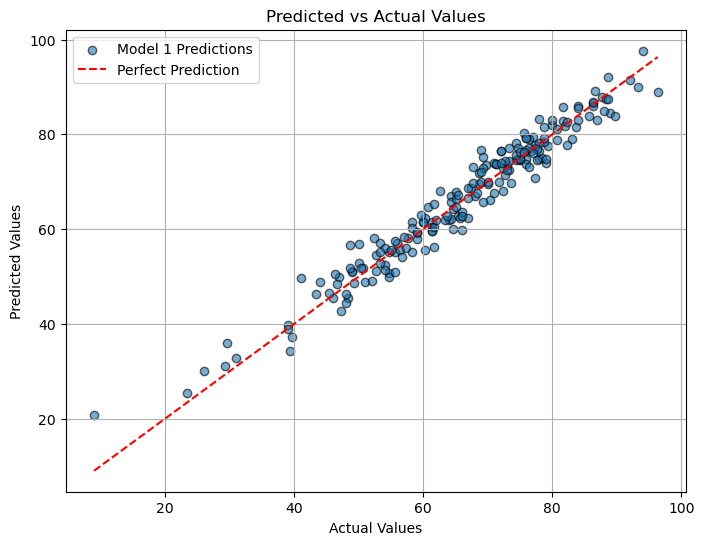

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot: Predicted values vs. Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_1, alpha=0.6, edgecolor='k', label='Model 1 Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')  # Diagonal line
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

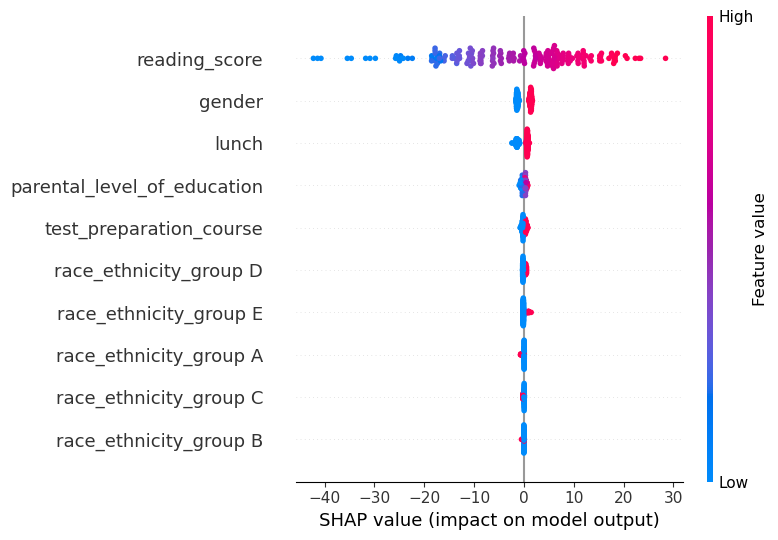

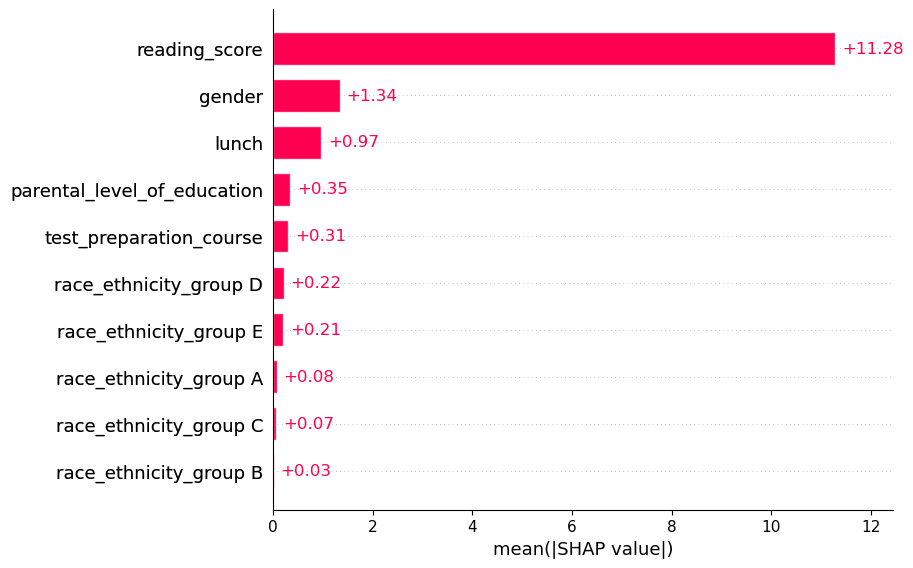

In [ ]:
chosen_pipeline = pipeline_1
chosen_model = chosen_pipeline.named_steps['model']

# Preprocess the test data using the pipeline's preprocessor
X_test_transformed = chosen_pipeline.named_steps['preprocessor'].transform(X_test)

# Extract the original feature names for transformed data
encoded_features = (
    numerical_features + 
    ['parental_level_of_education'] + 
    list(chosen_pipeline.named_steps['preprocessor']
         .transformers_[2][1]
         .named_steps['onehot']
         .get_feature_names_out(['race_ethnicity']))
)

# Ensure SHAP outputs display the correct feature names
explainer = shap.Explainer(chosen_model, X_test_transformed)
shap_values = explainer(X_test_transformed)
shap_values.feature_names = encoded_features

# Plot a summary of feature importance (global view)
shap.summary_plot(shap_values, X_test_transformed)

# Bar plot of average feature importance
shap.plots.bar(shap_values)

# Force plot for a specific prediction (e.g., the first test example)
shap.plots.force(shap_values[0])

plt.show()